## 1. Transformer Block

In [1]:
import torch
from torch import nn

In [2]:
# Defining the GPT configuration settings

GPT_Config_124M = {
    "vocab_size": 50257,
    "context_length": 256, 
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "dropout_rate": 0.0,
    "qkv_bias": False
}

In [3]:
# 1. Activation function
class GELUActivation(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        # Pass the input through the GELU activation - Approximate formula
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0) / torch.pi) * (x + 0.44715 * torch.pow(x, 3))))
        
# 2. Layer normalization
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        # Defining the epsilon -  small constant added to the variance to prevent zero division - undefined - limits
        self.eps = 1e-5
        # Defining the scaling and shifting parameters - trainable - better results
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        self.scale = nn.Parameter(torch.ones(emb_dim))
    # Forward pass
    def forward(self, x):
        # Getting the mean and variance of each row
        mean = x.mean(dim=-1, keepdim=True)
        variance = x.var(dim=-1, keepdim=True)
        # Getting the normalization values
        norm_x = (x - mean) / torch.sqrt(variance + self.eps)
        # Returning the normalized values of x shifted and scaled - finetuning parameters
        return self.scale * norm_x + self.shift
        
# 3. Feed forward        
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], cfg["emb_dim"]*4),
            GELUActivation(),
            nn.Linear(cfg["emb_dim"]*4, cfg["emb_dim"])
        )
    def forward(self, x):
        return self.layers(x)
# 4. Attention Mechanism
# Creating the multi-head attention compact class
import torch
from torch import nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout_rate, bias_units=False):
        super().__init__()
        assert d_out % num_heads == 0, "dimensions out must be divisible by number of heads"
        # Getting the head dimensions
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        # Initializing the key query value weights - (d_out, d_out)
        self.w_key = nn.Linear(d_in, d_out, bias=bias_units)
        self.w_query = nn.Linear(d_in, d_out, bias=bias_units)
        self.w_value = nn.Linear(d_in, d_out, bias=bias_units)
        # Initializing the final projection layer - optional - (d_out, d_out)
        self.out_proj = nn.Linear(d_out, d_out)
        # Creating the masking layer
        self.register_buffer("mask", torch.triu(
            torch.ones(context_length, context_length),
            diagonal = 1
        ))
        # Creating the dropout layer
        self.dropout = nn.Dropout(dropout_rate)
    # Forward pass    
    def forward(self, x):
        # Exploding the input shape
        b, num_tokens, d_out = x.shape
        # Getting the key query value matrices (b, num_tokens, d_out)
        keys = self.w_key(x)
        queries = self.w_query(x)
        values =  self.w_value(x)
        # Reshaping the key query value matrices - (b, num_tokens, num_head, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        # Grouping by number of heads - (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        # Getting the attention scores - (b, num_heads, num_tokens, num_tokens)
        attention_scores = queries @ keys.transpose(2, 3)
        # Masking the attention scores
        attention_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens],
            -torch.inf
        )
        # Scaling the attention scores
        attention_scores = attention_scores / keys.shape[-1]**0.5
        # Getting the attention weights
        attention_weights = torch.softmax(attention_scores, dim=-1)
        # Implementing the dropout layer
        attention_weights = self.dropout(attention_weights)
        # Getting the context vector - (b, num_heads, num_tokens, head_dim)
        context_vector = attention_weights @ values
        # Reshaping the context vectors - (b, num_tokens, num_heads, head_dim)
        context_vector = context_vector.transpose(1, 2)
        # Combining the result of mutiple heads - d_out = num_heads * head_dim
        context_vector = context_vector.contiguous().view(b, num_tokens, d_out)
        # Passing the final context vector into the projection layer - optional
        context_vector = self.out_proj(context_vector)
        return context_vector

In [4]:
# NB: Input = [b, num_tokens, 768]

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # Defining the normalization layers
        self.layerNorm1 = LayerNorm(cfg["emb_dim"])
        self.layerNorm2 = LayerNorm(cfg["emb_dim"])
        # Defining the dropout layers
        self.drop_shortcut = nn.Dropout(cfg["dropout_rate"])
        # Defining the Multi-Head Attention layer
        self.attention = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            num_heads = cfg["n_heads"],
            context_length = cfg["context_length"],
            dropout_rate = cfg["dropout_rate"],
            bias_units = cfg["qkv_bias"]
        )
        # Deefining the feed forward layer
        self.feed_forward = FeedForward(cfg)
    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.layerNorm1(x)
        x = self.attention(x)
        x = self.drop_shortcut(x)
        # Add the original input the output 
        x = x +  shortcut
        # Shortcut connection for the 
        x = shortcut
        x = self.layerNorm2(x)
        x = self.feed_forward(x)
        x = self.drop_shortcut(x)
        # Add the original output
        x = x + shortcut
        return x

## 2. GPT-Model

In [5]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # Defining the token embedding layer
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        # Defining the positional embedding layer
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        # Defining the dropout layer 
        self.drop_emb = nn.Dropout(cfg["dropout_rate"])
        # Defining the transformer blocks
        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        # Defining the final normalization layer
        self.final_norm = LayerNorm(cfg["emb_dim"])
        # Defining the final linear layer
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
    # Forward pass
    def forward(self, in_idx):
        # Explosion of shape
        batch_size, seq_len = in_idx.shape
        # Getting the token embeddings
        token_embeddings = self.tok_emb(in_idx)
        # Getting the positional embeddings
        positional_embeddings = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        # Getting the input embeddings
        input_embeddings = token_embeddings + positional_embeddings
        # Passing the input embeddings through the dropout layer
        input_embeddings = self.drop_emb(input_embeddings)
        # Passing the input embeddings through the transformer blocks
        input_embeddings = self.transformer_blocks(input_embeddings)
        # Passing the input embeddings through the final normalization layer
        input_embeddings = self.final_norm(input_embeddings)
        # Passint the input embeddings through the final linear layer to get logits
        logits = self.out_head(input_embeddings)
        return logits

In [6]:
# Example of instantiation

sample_batch = torch.tensor([[6109, 3636, 6100, 345],[6109, 1110, 6622, 257]])
print(sample_batch.shape)
torch.manual_seed(42)
model = GPTModel(GPT_Config_124M)
out = model(sample_batch)
print(out.shape)

torch.Size([2, 4])
torch.Size([2, 4, 50257])


In [7]:
# Checking the number of parameters

total_params = sum(p.numel() for p in model.parameters())
total_params

162419712

- We can see this is not same as the original plan of 124M instead we have 163M
- This is due to a concept weight tying
- The GPT architechts reused the weight for the token embedding layer in the output layer

In [8]:
# Confirming shapes match

model.out_head.weight.shape == model.tok_emb.weight.shape

True

In [9]:
model.out_head.weight.shape

torch.Size([50257, 768])

In [10]:
model.tok_emb.weight.shape

torch.Size([50257, 768])

In [11]:
# Confirming the theory of weight reusal

GPT_MODEL_PARAMS = total_params - sum(p.numel() for p in model.out_head.parameters())
GPT_MODEL_PARAMS

123822336

## 3.Generating output tokens

In [12]:
# Check LLM book for further clarification

def generate_tokens_simple(model, idx, max_num_tokens, context_size):
    # Number of iterations - number of new tokens to be generated
    for _ in range(max_num_tokens):
        # idx.shape = [batch, num_tokens] e.g = [2, 2]
        # Slicing - making sure the context size = 5 if not select last 5 tokens
        idx_condition = idx[:, -5:]
        # Making predictions - getting the logits - logits.shape = [b, num_tokens, vocab_size]
        with torch.no_grad():
            logits = model(idx_condition)
        # Extracting the last token row - logits[:, -1, :].shape = [b, 1, vocab_size]
        logits = logits[:, -1, :]
        # Converting the logits into probabilities - exponential sum
        probabilities = torch.softmax(logits, dim=-1)
        # Getting the element with the highest probability
        idx_next = torch.argmax(probabilities, dim=-1, keepdim=True)
        # Appending the predicted token to the running sequence
        # idx = [b, num_tokens+1]
        # We are concatenating along the last dimension which in this case is the last dimension
        idx = torch.cat((idx, idx_next), dim=1)
    # Returning the full sequence = original + generated upto max number of tokens
    return idx   

## Testing Generation using real text

In [13]:
# Encoding text to token ids
import tiktoken

starting_context = "Hello, I am Jacob from Congo"
tokenizer = tiktoken.get_encoding("gpt2")
encoded = tokenizer.encode(starting_context)
print("Encoded text = ", encoded)
# Converting the encode into a tensor
# The unsqueeze - we are adding an dimension: [num_tokens] ---> [b, num_tokens]
encoded = torch.tensor(encoded).unsqueeze(0)
print("Encoded tensor = ", encoded, "Shape = ", encoded.shape)

Encoded text =  [15496, 11, 314, 716, 12806, 422, 25935]
Encoded tensor =  tensor([[15496,    11,   314,   716, 12806,   422, 25935]]) Shape =  torch.Size([1, 7])


In [14]:
# Generating text using our model

# Setting the evaluation/testing mode - cancels some unnecessary components e.g dropout layers
model.eval()
output_tensor = generate_tokens_simple(
    model = model,
    idx = encoded,
    max_num_tokens = 6,
    context_size = GPT_Config_124M["context_length"]
)
print(f"Output tensor = {output_tensor} Output tensor shape = {output_tensor.shape}")

Output tensor = tensor([[15496,    11,   314,   716, 12806,   422, 25935, 30543, 15508, 29900,
         37257, 13825, 26687]]) Output tensor shape = torch.Size([1, 13])


In [15]:
# Decoding the output tensor - remember we need to squeeze the first batch dimension
# Note that the tiktoken doesnt work with tensor so use python lists or numpy arrays

decoded_text = tokenizer.decode(output_tensor.squeeze(0).numpy())
decoded_text

'Hello, I am Jacob from Congo"\' teens undergone tightened obesityReference'

## Creating decode and encoder class

In [16]:
# Creating the decoder and encoder functions
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
# Encoder function
def encoder(sample_text, tokenizer=tokenizer):
    encoded_tensor = torch.tensor(tokenizer.encode(sample_text, allowed_special={"<|endoftext|>"})).unsqueeze(0)
    return encoded_tensor
# Decoder function
def decoder(encoded_tensor, tokenizer=tokenizer):
    decoded_text = tokenizer.decode(encoded_tensor.squeeze(0).numpy())
    return decoded_text    

In [17]:
# Testing the class
sample_text = "Every effort moves you"
token_ids = generate_tokens_simple(
    model = model,
    idx = encoder(sample_text, tokenizer),
    max_num_tokens = 6,
    context_size = GPT_Config_124M["context_length"]
)
token_ids

tensor([[ 6109,  3626,  6100,   345, 35300, 29583, 24889,  7113, 39862, 30189]])

## Creating Input - target pairs

In [18]:
# effort moves you -- I really like
inputs = torch.tensor([[16833, 3626, 6100],[40, 1107, 588]])
# moves you forward -- really like chocolate
targets = torch.tensor([[3626, 6100, 345], [1107, 588, 11311]])
inputs.shape, targets.shape

(torch.Size([2, 3]), torch.Size([2, 3]))

In [19]:
# Getting the predictions for the inputs - We have a third row which is the prediction
with torch.no_grad():
    logits = model(inputs)
logits, logits.shape   

(tensor([[[ 0.3570,  0.6767, -0.5159,  ..., -0.6060,  0.3366, -0.0650],
          [ 0.0936,  0.2446, -0.0886,  ..., -0.4846, -0.0741,  1.2275],
          [-0.5307, -0.0697,  0.5274,  ..., -0.0065, -1.1845,  0.6131]],
 
         [[-0.0906,  0.5485,  0.2573,  ...,  0.1525,  0.2995,  0.7435],
          [-0.3525,  0.4848, -0.1509,  ..., -0.0295,  0.4599,  1.4260],
          [ 0.7239, -0.8283,  0.3101,  ..., -0.5223, -0.7993, -1.4578]]]),
 torch.Size([2, 3, 50257]))

In [20]:
# We have three prediction tasks for every row but we will focus on the last one

probas = torch.softmax(logits, dim=-1)
outputs = torch.argmax(probas, dim=-1, keepdim=True)
outputs, outputs.shape

(tensor([[[42217],
          [35523],
          [ 5243]],
 
         [[29716],
          [ 8185],
          [42456]]]),
 torch.Size([2, 3, 1]))

In [21]:
outputs.flatten()

tensor([42217, 35523,  5243, 29716,  8185, 42456])

In [22]:
# Checking how far from true value we are

print(f"Targets batch 1: {decoder(targets[0].flatten())}")
print(f"Outputs batch 1: {decoder(outputs[0].flatten())}")

Targets batch 1:  effort moves you
Outputs batch 1:  ceasesThumbnail radio


## Binary Cross Entropy Loss

In [23]:
# Checking the inputs

inputs, inputs.shape

(tensor([[16833,  3626,  6100],
         [   40,  1107,   588]]),
 torch.Size([2, 3]))

In [24]:
# Checking the targets

targets, targets.shape

(tensor([[ 3626,  6100,   345],
         [ 1107,   588, 11311]]),
 torch.Size([2, 3]))

In [25]:
# Getting the probabilities

with torch.no_grad():
    logits = model(inputs)
    probas = torch.softmax(logits, dim=-1)
probas, probas.shape    

(tensor([[[2.4135e-05, 3.3229e-05, 1.0082e-05,  ..., 9.2138e-06,
           2.3649e-05, 1.5826e-05],
          [1.8456e-05, 2.1465e-05, 1.5382e-05,  ..., 1.0352e-05,
           1.5607e-05, 5.7356e-05],
          [9.8770e-06, 1.5661e-05, 2.8455e-05,  ..., 1.6683e-05,
           5.1364e-06, 3.1000e-05]],
 
         [[1.5358e-05, 2.9099e-05, 2.1748e-05,  ..., 1.9584e-05,
           2.2686e-05, 3.5367e-05],
          [1.1778e-05, 2.7209e-05, 1.4408e-05,  ..., 1.6268e-05,
           2.6540e-05, 6.9736e-05],
          [3.4703e-05, 7.3491e-06, 2.2944e-05,  ..., 9.9808e-06,
           7.5656e-06, 3.9162e-06]]]),
 torch.Size([2, 3, 50257]))

A. Long Method

In [26]:
# Advanced indexing

# Getting the probabilities for the first text
text1_idx = 0
text1_probas = probas[text1_idx, range(3), targets[text1_idx]]
# Getting the probabilities for the second text
text2_idx = 1
text2_probas = probas[text2_idx, range(3), targets[text2_idx]]
text1_probas, text2_probas

(tensor([3.2132e-06, 4.8871e-05, 8.0817e-06]),
 tensor([1.8494e-05, 2.7398e-05, 7.3609e-06]))

In [27]:
# Merging the probabilities calculating the log probabilities
text_probas = torch.cat((text1_probas, text2_probas), dim = -1)
print("Merged probabilities: ", text_probas)
# Calculating the log probabilities
log_text_probas = torch.log(text_probas)
print("Log of merged probabilities: ", log_text_probas)
# Getting the average log probabilities value
avg_log_probas = torch.mean(log_text_probas)
print("Average log probability: ", avg_log_probas)
# Getting the negative average log probabily value = loss
loss = - avg_log_probas
print("Negative average log probability: ", loss)

Merged probabilities:  tensor([3.2132e-06, 4.8871e-05, 8.0817e-06, 1.8494e-05, 2.7398e-05, 7.3609e-06])
Log of merged probabilities:  tensor([-12.6483,  -9.9263, -11.7259, -10.8981, -10.5050, -11.8193])
Average log probability:  tensor(-11.2538)
Negative average log probability:  tensor(11.2538)


B. Shortcut method

In [28]:
print("Original logits shape: ", logits.shape)
print("Targets Original shape: ", targets.shape)
# Flattening the first two dimension of the logits
logits_flatten = logits.flatten(0, 1)
# Flattening the targets 
targets_flatten = targets.flatten()
print("New shapes")
logits_flatten.shape, targets_flatten.shape

Original logits shape:  torch.Size([2, 3, 50257])
Targets Original shape:  torch.Size([2, 3])
New shapes


(torch.Size([6, 50257]), torch.Size([6]))

In [29]:
# Calculating the loss
loss = torch.nn.functional.cross_entropy(logits_flatten, targets_flatten)
loss

tensor(11.2538)

## Perplexity Score - Exponential of loss - Much more inteprable than loss

- Lower perplexity score means a better model
- **NB** A common misconception is that perplexity score ranges [1, num_classes] but not the case
- Perplexity >= 1
- The closer it is to one the better the model

In [30]:
# Getting the perplexity score for our model so far

perplexity_score = torch.exp(loss)
perplexity_score

tensor(77174.2656)

In [31]:
# Testing using a different input
sample_inputs = "Hello my name is Melvyn."
sample_targets = "I am a student."
encoded_inputs = encoder(sample_inputs)
encoded_targets = encoder(sample_targets)
encoded_inputs, encoded_targets

(tensor([[15496,   616,  1438,   318,  5616,    85,  2047,    13]]),
 tensor([[  40,  716,  257, 3710,   13]]))

In [32]:
predicted_targets = generate_tokens_simple(
    model = model,
    idx = encoded_inputs,
    max_num_tokens=5,
    context_size = GPT_Config_124M["context_length"]
)
predicted_targets

tensor([[15496,   616,  1438,   318,  5616,    85,  2047,    13, 39662, 15887,
          4538,  1368, 27702]])

## Training and Validation loss - Real Dataset(the verdict story)

In [33]:
# Reading data 

with open(r"C:\Users\nyasa\Downloads\BUILDING LLM FROM SCRATCH\Stage1\1.Data Preparation and Sampling\1.Tokenization\1.Word-Based-Tokenization\the-verdict.txt", "r") as f:
    text_data = f.read()
text_data[:1000]

'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)\n\n"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it\'s going to send the value of my picture \'way up; but I don\'t think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing\'s lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn\'s "Moon-dancers" to say, with tears in her eyes: "We shall not look upon its like again"?\n\nWell!--even 

In [34]:
# Checking number of charachters

print("Sample text has charachters = ", len(text_data))

Sample text has charachters =  20479


In [35]:
# Tokenization

token_ids = encoder(text_data).squeeze(0)
print("Sample text has tokens = ", len(token_ids)), token_ids.shape

Sample text has tokens =  5145


(None, torch.Size([5145]))

In [36]:
# Implementing the dataloader - input pair targets
from torch.utils.data import DataLoader

class InputPairTargetsV1:
    def __init__(self, text, context_length, stride):
        tokenizer = tiktoken.get_encoding("gpt2")
        token_ids = tokenizer.encode(text)
        self.input_ids = []
        self.target_ids = []
        for i in range(0, len(token_ids)-context_length, stride):
            input_chunk = token_ids[i: context_length+i]
            target_chunk = token_ids[i+1:context_length+i+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk)) 
    def __len__(self):
        return len(self.input_ids)
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def dataloader(text, context_length=256, stride=128, batch_size=4, workers=0, drop=True, shuffle=True):
    dataset = InputPairTargetsV1(text, context_length, stride)
    dataloader = DataLoader(
        dataset = dataset,
        batch_size = batch_size,
        num_workers = workers,
        drop_last = drop
    )
    return dataloader

In [37]:
# Train and Validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
validation_data = text_data[split_idx:]
# Sanity check 
if len(tokenizer.encode(text_data)) * train_ratio < GPT_Config_124M["context_length"]:
    print("Not  enough tokens for the training dataloader try a smaller context length or increase the training ratio")
if len(tokenizer.encode(text_data)) * (1 - train_ratio) < GPT_Config_124M["context_length"]:
    print("Not  enough tokens for the validation dataloader try a smaller context length or reduce the training ratio")    
# Creating the train and validation dataloders
torch.manual_seed(42)
train_dataloader = dataloader(
    train_data,
    context_length = GPT_Config_124M["context_length"],
    stride = GPT_Config_124M["context_length"],
    batch_size = 2
)
validation_dataloader = dataloader(
    validation_data,
    context_length = GPT_Config_124M["context_length"],
    stride = GPT_Config_124M["context_length"],
    batch_size = 2
)

In [38]:
# Making sure the data is loaded correctly 

print("Train dataloader")
for x, y in train_dataloader:
    print(x.shape, y.shape)
print("Number of batches = ", len(train_dataloader))    
print("Validation dataloader")
for x, y in validation_dataloader:
    print(x.shape, y.shape)
print("Number of batches = ", len(train_dataloader))    

Train dataloader
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
Number of batches =  9
Validation dataloader
torch.Size([2, 256]) torch.Size([2, 256])
Number of batches =  9


In [39]:
# Optional Second check

number_of_elements = 0
for input_batch, target_batch in train_dataloader:
    number_of_elements += input_batch.numel()
for input_batch, target_batch in validation_dataloader:
    number_of_elements += input_batch.numel()
print(number_of_elements, len(tokenizer.encode(text_data)))  

5120 5145


## Calculating the loss of batch

In [40]:
# Calculating the loss of a single batch
def calculateLossBatch(input_batch, target_batch, model, device):
    # Setting the device
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    # Getting the logits for the input batch
    logits = model(input_batch)
    # Getting the loss
    loss = nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss
    
# Calculating the cumulative loss of all the batches
def calculateTotalLoss(dataloader, model, device, num_batches=None):
    total_loss = 0
    # No batches present
    if len(dataloader) == 0:
        return float("nan")
    # If number of batches is not given
    elif num_batches is None:
        num_batches = len(dataloader)
    else:
        # If number of batches specified is more than the number of batches in the dataloader reduce
        num_batches = min(num_batches, len(dataloader))
    # Iterate the dataloader
    for i, (input_batch, target_batch) in enumerate(dataloader):
        if i < num_batches:
            loss = calculateLossBatch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    # Calculatin the mean loss            
    return total_loss / num_batches

In [41]:
# Setting the device 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [42]:
# Setting te model to the available device

model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (layerNorm1): LayerNorm()
      (layerNorm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
      (attention): MultiHeadAttention(
        (w_key): Linear(in_features=768, out_features=768, bias=False)
        (w_query): Linear(in_features=768, out_features=768, bias=False)
        (w_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELUActivation()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerBlock(
      (layerNorm1): LayerN

In [43]:
# Calculating the loss

torch.manual_seed(42)
with torch.no_grad():
    train_loss = calculateTotalLoss(train_dataloader, model, device)
    validation_loss = calculateTotalLoss(validation_dataloader, model, device)
print("Training loss = ", train_loss)    
print("Validation loss = ", validation_loss)    

Training loss =  11.005153867933485
Validation loss =  11.034592628479004


## Creating the entire pretraining-loop

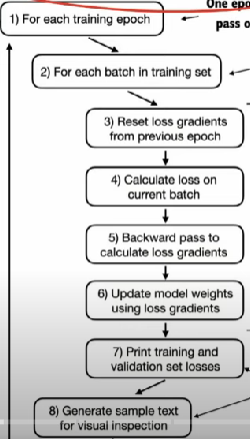

In [44]:
# Creating the evaluation function

def evaluate_model(train_dataloader, validation_dataloader, model, device, eval_iter):
    # Setting evaluation mode
    model.eval()
    with torch.no_grad():
        train_loss = calculateTotalLoss(train_dataloader, model, device, num_batches = eval_iter)
        validation_loss = calculateTotalLoss(validation_dataloader, model, device, num_batches = eval_iter)
    # Setting back to training mode
    model.train()
    return train_loss, validation_loss

# Creating function to generate simple text

def generateAndPrintSample(sample_text, tokenizer, model, device):
    # Setting the context size
    context_size = model.pos_emb.weight.shape[0]
    # Encoding the sample text
    idx = encoder(sample_text, tokenizer)
    # Setting training mode
    model.eval()
    with torch.no_grad():
        token_ids = generate_tokens_simple(
            model = model, 
            idx = idx, 
            max_num_tokens=40,
            context_size = context_size
        )
    # Decoding the output
    decoded_text = decoder(token_ids, tokenizer)
    color = "\033[1;32m"
    cleaned_text = decoded_text.replace('\n', ' ')
    print(f"{color}Generated text = {cleaned_text}\033[0m")


    
# Creating a pretraining loop function
from tqdm.auto import tqdm

def pretrainingLoop(num_epochs, train_dataloader, validation_dataloader, model, device, optimizer, eval_freq, eval_iter, sample_text, tokenizer):
    # Creating storage for losses and token tracking
    train_losses, validation_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    # Iterating the epochs - all batches forward pass per epoch
    for epoch in tqdm(range(num_epochs)):
        # Setting training mode
        model.train()
        # Iterating through batches
        for input_batch, target_batch in train_dataloader:
            # Resetting the loss gradients for the previous batch
            optimizer.zero_grad()
            # Calculating the loss of the batch
            loss = calculateLossBatch(input_batch, target_batch, model, device)
            # Calculating the loss gradients
            loss.backward()
            # Back propagating loss gradients
            optimizer.step()
            # Updating the global step - evaluation metric
            global_step += 1
            # Evaluation by calculating loss with current weights - Optional
            if global_step % eval_freq == 0:
                # Getting the training and validation loss for the entire model
                train_loss, validation_loss = evaluate_model(train_dataloader, validation_dataloader, model, device, eval_iter)
                train_losses.append(train_loss)
                validation_losses.append(validation_loss)
                # Updating the tokens seen tracking store
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch = {epoch + 1} - global step = {global_step}")
        # After each epoch generate some text to see results
        generateAndPrintSample(sample_text, tokenizer, model, device)
    return train_losses, validation_losses, track_tokens_seen

In [45]:
# Testing the pretraining loop
import time
start_time = time.time()
# Setting the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
# Setting the number of epochs
num_epochs = 10
torch.manual_seed(42)
train_losses, validation_losses, track_tokens_seen = pretrainingLoop(
    num_epochs = num_epochs, 
    train_dataloader = train_dataloader, 
    validation_dataloader=validation_dataloader,
    model = model, 
    device = device, 
    optimizer = optimizer,
    eval_freq=5,
    eval_iter=5,
    sample_text="Every effort moves you",
    tokenizer=tokenizer
)
end_time = time.time()
execution_time = (-start_time + end_time) / 60
print(f"Total execution time = {execution_time}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch = 1 - global step = 0
Epoch = 1 - global step = 5
Generated text = Every effort moves you.                                       
Epoch = 2 - global step = 10
Epoch = 2 - global step = 15
Generated text = Every effort moves you. ". ". ". ". ". ". ". ". ". ". ". ". ".
Epoch = 3 - global step = 20
Epoch = 3 - global step = 25
Generated text = Every effort moves you know.                                      
Epoch = 4 - global step = 30
Epoch = 4 - global step = 35
Generated text = Every effort moves you in the he was _ he was _ he was _ he was _ he was _ he was _ he was _ he was _ he was _ he was _ he was _ he was _ he was
Epoch = 5 - global step = 40
Generated text = Every effort moves you in the terrace of Hermia he said.                              
Epoch = 6 - global step = 45
Epoch = 6 - global step = 50
Generated text = Every effort moves you?"                                       
Epoch = 7 - global step = 55
Epoch = 7 - global step = 60
Generated text = Every effort move

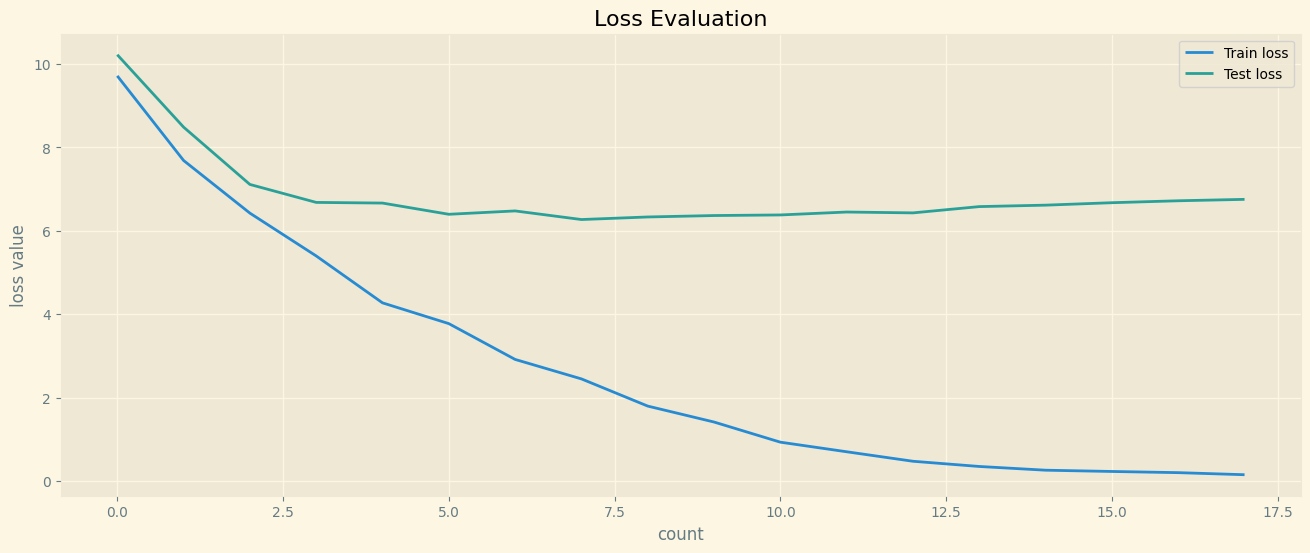

In [46]:
# Checking the loss values 
import matplotlib.pyplot as plt

with plt.style.context(plt.style.available[0]):
    plt.figure(figsize=(16, 6))
    plt.plot(range(len(train_losses)), train_losses, label="Train loss")
    plt.plot(range(len(validation_losses)), validation_losses, label = "Test loss")
    plt.xlabel("count")
    plt.ylabel("loss value")
    plt.title("Loss Evaluation")
    plt.grid(1)
    plt.legend()

In [47]:
# Making some simple predictions on seen data

sample_text = text_data[:100]
# Getting the predicted sequence
token_ids = generate_tokens_simple(
    model = model, 
    idx = torch.tensor(tokenizer.encode(sample_text)).unsqueeze(0),
    max_num_tokens=100,
    context_size=5
)
# Decoding the model output
decoded_text = tokenizer.decode(token_ids.squeeze(0).numpy())
decoded_text

'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g. It was without that he without that he without that he without that he without that he without that he without that he without that he without that he without that he without that he without that he without that he without that he without that he without that he without that he without that he without that he without that he without that he without that he without that he without that he without that he without that he without that he without that he without that he without that he without that he without that he without'